# Build, criticise, and expand time series models with NumPyro
> Bayesian modeling of global trend, local variation, seasonality, and heterogeneity in time series

- toc: true 
- badges: true
- comments: true
- categories: [Data]




In this post we'll implement a time series framework based on a flexible
smoothed exponential process. The framework can be used to model global
trend, local variation, seasonality and other features that are
essential for flexible time series modeling.

This post also covers several other features under this general
framework, notably:

-   modeling over-dispersed observations with Student-T distribution
-   explicit and extensive modeling of the variation to capture data
    heteroscedasticity
-   adding regression components when necessary

Some other general but important features include:

-   extensive usage of visualisation for model criticism
-   prior and posterior simulation for model inspection
-   and a unified prediction framework.

Last but maybe most importantly, apart from the specific features and
techniques, the post gives a general procedure for Bayesian model
building and criticism, which should be useful for building any kind of
model for any kind of data.

This is mostly a port of the R package [Rlgt: Bayesian Exponential Smoothing Models with Trend Modifications](https://cran.r-project.org/web/packages/Rlgt/index.html), although the implementation details might differ here and there. One of the models has already been [ported to Numpyro](http://num.pyro.ai/en/stable/tutorials/time_series_forecasting.html) in one of the Numpyro tutorials, so that specific model is not covered here.

Different options for modeling trends and seasonalities have been
considered in this post, to understand their varying capabilities and
characteristics, and to prepare an arsenal for building bespoke models
for future data sets with different characteristics.



In [1]:
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns
sns.set_theme(palette='Set2')
colors = sns.color_palette()

import jax.numpy as jnp
from jax import random
from jax import lax, nn
from jax.config import config; config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=2)
rng = random.PRNGKey(123)

import numpyro
numpyro.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro import deterministic, sample
from numpyro.handlers import seed, condition, plate

import daft

from rdatasets import data, descr, summary
%config InlineBackend.figure_format = 'retina'



We are going to use two data sets, the BJ sales data and the monthly
airline passenger data set. For the BJ sales data set we have an extra
lead indicator, which can be used to build a regression component to the
model.


In [2]:
bj = data("BJsales")['value']
air_passengers = data("AirPassengers")['value']
bj_lead = jnp.array(
    [10.01,10.07,10.32, 9.75,10.33,10.13,10.36,10.32,10.13,10.16,10.58,10.62, 10.86,11.20,10.74,10.56,10.48,10.77,11.33,10.96,11.16,11.70,11.39,11.42, 11.94,11.24,11.59,10.96,11.40,11.02,11.01,11.23,11.33,10.83,10.84,11.14, 10.38,10.90,11.05,11.11,11.01,11.22,11.21,11.91,11.69,10.93,10.99,11.01, 10.84,10.76,10.77,10.88,10.49,10.50,11.00,10.98,10.61,10.48,10.53,11.07, 10.61,10.86,10.34,10.78,10.80,10.33,10.44,10.50,10.75,10.40,10.40,10.34, 10.55,10.46,10.82,10.91,10.87,10.67,11.11,10.88,11.28,11.27,11.44,11.52, 12.10,11.83,12.62,12.41,12.43,12.73,13.01,12.74,12.73,12.76,12.92,12.64, 12.79,13.05,12.69,13.01,12.90,13.12,12.47,12.47,12.94,13.10,12.91,13.39, 13.13,13.34,13.34,13.14,13.49,13.87,13.39,13.59,13.27,13.70,13.20,13.32, 13.15,13.30,12.94,13.29,13.26,13.08,13.24,13.31,13.52,13.02,13.25,13.12, 13.26,13.11,13.30,13.06,13.32,13.10,13.27,13.64,13.58,13.87,13.53,13.41, 13.25,13.50,13.58,13.51,13.77,13.40])



These data sets have different characteristics and as such will demand
different modeling considerations.



## Modeling global trend and local variation



The data used for this model is the
[BJsales](https://vincentarelbundock.github.io/Rdatasets/doc/datasets/BJsales.html)
data set, which contains 150 sales observations. The data are bounded by
zero, as can be expected for sales data, and range between 200 and 300,
and there is very little variation between neighbouring points.


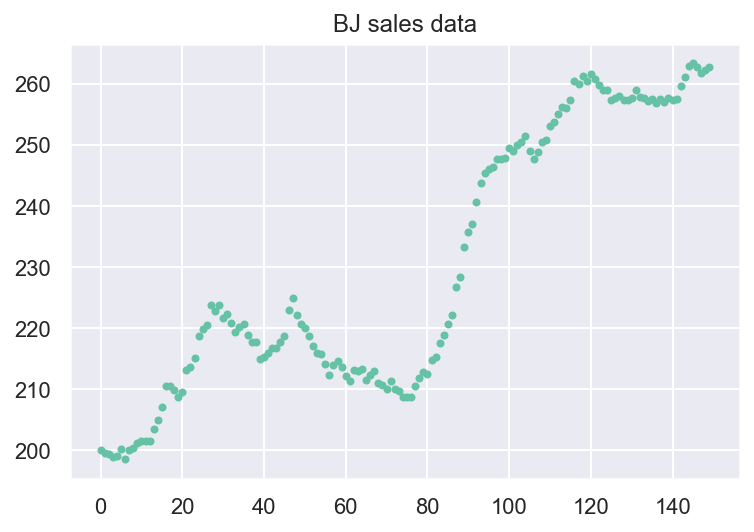

In [3]:
lgt_y = jnp.array(bj)

plt.plot(bj, '.')
plt.title('BJ sales data');



The first model we are building can be described as

\begin{align*}
y_{t} &\sim \text{T} (\nu,\mu_{t}, \sigma_{t}) \\
\sigma_{t} &= \kappa \mu_{t}^{ \tau} + \xi   \\
\mu_{t} &= \text{G}_{t} + \text{L}_{t} \\
\text{G}_{t} &= g_{t-1} + \gamma g_{t-1}^{ \rho } \\
\text{L}_{t} &= \lambda l_{t-1}  \\
g_{t} &= \alpha y_{t} + ( 1- \alpha ) \text{G}_{t} \\
l_{t} &= \beta  \left( g_{t}-g_{t-1} \right) + \left( 1- \beta  \right) l_{t-1}\\
\end{align*}



This first model is already quite complex so let's spend a moment to digest it. We can visualise the model as follows

![](lgts0.jpeg)


The variable $y$ in the above graph is shaded because it's the observed variable. One thing to keep in mind with Bayesian networks, is that they form directed acyclical graphs, that is, there shouldn't be circles anywhere in the model. We can check that this is indeed the case with the above model.


To model the outcome we'll use the Student's T distribution, which has
three parameters: the degree of freedom $\nu$, the expected value $\mu$,
and the standard deviation $\sigma$.




The degree of freedom determines how heavy tailed the distribution will
be: when the degree of freedom is one, the T distribution becomes the Cauchy
distribution, which is so heavy tailed that the mean and standard
deviation can not even be properly defined; when the degree of freedom
approaches infinity the distribution approaches Normal, with quite narrow
tails. Using the T distribution, we can account for heavy tail data when
the data are indeed heavy tailed, but it's also flexible enough for when
they are not. Since à priori we don't have much information on the
degree of freedom, we'll put a wide prior on it.



The expected value is where we'll put most of our modeling focus on. In
this first model we'll consider modeling it as the sum of a global trend
$\text{G}$ and a local variation $\text{L}$, with the global trend being
modeled as a smoothed exponential function of the hidden level $g$, and
the local variation as a dampened baseline variation $l$. Furthermore,
both the hidden level $g$ and the variation $l$ follow a smoothed
autoregressive process. For hidden level $g$, it's a weighted average
between the outcome, and the previous global
trend. For the baseline variation $l$ it's a weighted average between
the increment in hidden levels, and the previous baseline variation.
$\alpha$ and $\beta$ are the corresponding smoothing weights.



The standard deviation is modeled with another smoothed exponential
process of the expected value, so this is a heterogeneous model, with the
variance varying alongside the expected value.


Some of the modeling assumptions might look a bit arbitrary; and they indeed are. There are a thousand choices we can make about how each piece of the model is formulated, and sometimes we have to try different alternatives to see which works best for our data.


Because both the standard deviation $\sigma$ and the expected value
$\mu$ follow a smoothed exponential process, we have to guarantee the
expected value and the hidden level $g$ be always positive. This
assumption is reasonable when the data is also positive, as is the case
here.



It's important to note that the models we are building might be too
complex for the data we are using. Here by exploratory analysis we can
see that the BJ sales data have a global trend, and there are clearly
local variations, but there doesn't seem to be many sudden changes in
the series, and as such the smoothed exponential process for the
standard deviation might not be strictly necessary. Still, we use a more
complex model to account for the **potential** heterogeneities in the
data.



Now we can chose some proper priors for the model parameters and code
the model in NumPyro. Of course, choosing priors is an integral part of
Bayesian modeling and it is no easy task, we need to consider our
prior knowledge carefully and gradually update that in model criticism.
The priors chosen for this model implementation take into account both
the model structure, and the general knowledge we have gained from
exploratory data analysis. In Bayesian analysis each model should be a
bespoke model for the specific data set we are modeling.


Because this is a time series model, we use the first observation to
initialise the model. Specifically, we'll use it to indicate the
starting whereabouts of the hidden level $g$.



``` python
def lgt(y, future=3):
    N = y.shape[0]
    nu = sample("nu", dist.Uniform(1, 50))

    xi = sample("xi", dist.HalfNormal(2))
    tau = sample("tau", dist.Beta(1, 4))
    kappa = sample("kappa", dist.HalfNormal(2))

    gamma = sample("gamma", dist.HalfNormal(2))
    rho = sample("rho", dist.Beta(1, 4))

    lbda = sample("lbda", dist.Beta(2, 2))
    alpha = sample("alpha", dist.Beta(2, 2))
    beta = sample("beta", dist.Beta(2, 2))

    g_init = sample("g_init", dist.Normal(y[0], 5))
    l_init = sample("l_init", dist.Normal(0, 10))

    def transition_fn(carry, t):
        g, l = carry
        G = deterministic("G", g + gamma * g ** rho)
        L = deterministic("L", lbda * l)
        mu = deterministic("mu", jnp.clip(G + L, 0))
        sigma = deterministic("sigma", xi + kappa * mu ** tau)

        yt = sample("y", dist.StudentT(nu, mu, sigma))

        g_new = deterministic("g", jnp.clip(alpha * yt + (1 - alpha) * G, 0))
        l_new = deterministic("l", beta * (g_new - g) + (1 - beta) * l)

        return (g_new, l_new), yt

    with condition(data={'y':y}):
        _, ys = scan(transition_fn, (g_init, l_init),  jnp.arange(0, N+future))

    return ys

print("Observed data:", lgt_y[:4])

with seed(rng_seed=3):
    print("\nPrior sampling:")
    print(lgt(lgt_y[:1], future=3))
    print("\nFixed data sampling:")
    print(lgt(lgt_y[:4], future=0))
```

With the model specified we can draw prior samples from it. We can
generate prior samples without the observed data, because our model is
completely generative. We also write a simple helper function
`check_prior` to collect model variables and print out summary
statistics. The model variables are separated into two groups: global
variables, which determine the behaviour of the whole model; and local
variables which are specific to each observed outcome.

``` python
lgt_prior = Predictive(lgt, num_samples=500)(rng, lgt_y[:1], 139)

def check_prior(prior):
    """Print out prior shapes,
    collect local and global variables into lists."""
    lvs = []
    gvs = []
    y_length = prior['y'].shape[-1]
    for k, v in prior.items():
        if v.ndim == 1:
            gvs.append(k)
        elif v.shape[1] == y_length:
            lvs.append(k)
        else:
            gvs.append(k)

    print("Global variables:")
    for k in gvs:
        print(k, prior[k].shape, end='; ')
    print("\n\nLocal variables:")
    for k in lvs:
        print(k, prior[k].shape, end='; ')

    return lvs, gvs

lgt_lvs, lgt_gvs = check_prior(lgt_prior)
```

It's important to check the model prior predictions to make sure the
model indeed has the desired properties we intended for. We can use a
parallel plot in which each sample will be plotted as one single line
across different coordinates. While doing so, we'll also differentiate
the normal samples, that is that intended samples of our model, from
samples with extremely large outcomes, and also from samples with
numerical overflows. The samples with numerical overflow will be in red,
while those with extreme outcomes will be in blue.

Here we first write another helper function `concat_arrays` to
concatenate one or two dimensional arrays stored in a dict, as is the
case with our prior and posterior samples. And if the variable is
multivariate, we also break down its dimensions into separate variables.
This is to facilitate later visualisation.

``` python
def concat_arrays(dct, vs):
    nvs = []
    ds = []
    for v in vs:
        d = dct[v]
        if d.ndim == 2:
            vplus = [v+str(i) for i in range(d.shape[-1])]
            nvs += vplus
            ds.append(d)
        else:
            nvs.append(v)
            ds.append(d[:, None])

    ds = jnp.concatenate(ds, axis=1)

    return nvs, ds


nvs, ds = concat_arrays(lgt_prior, ['gamma', 'rho'])
print(len(nvs), ds.shape)  # 1+1=2, (500, 2)

nvs, ds = concat_arrays(lgt_prior, ['g', 'l'])
print(len(nvs), ds.shape)  # 140+140=280, (500, 280)

nvs, ds = concat_arrays(lgt_prior, ['gamma', 'l', 'rho'])
print(len(nvs), ds.shape)  # 1+140+1=142, (500, 142)
```

And plot the global parameters of the model

``` python
def compare_global_params(dct, vs, v_ref='y', val_ref=10000):
    # TODO add custom labels to different groups

    nans = jnp.any(jnp.isnan(dct[v_ref]), axis=1)
    extremes = jnp.any(dct[v_ref] > val_ref, axis=1)
    print('Number of samples with numerical overflows: ', nans.sum())
    print('Number of samples with extreme values : ', extremes.sum())

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
    nvs, ds = concat_arrays(dct, vs)

    for i in range(ds.shape[0]):
        if not nans[i]:
            if not extremes[i]:
                ax.plot(ds[i], color=colors[0], alpha=0.1, lw=1)

    for i in range(ds.shape[0]):
        if not nans[i]:
            if extremes[i]:
                ax.plot(ds[i], color='r', alpha=0.2, lw=1)

    for i in range(ds.shape[0]):
        if nans[i]:
            ax.plot(ds[i], color='k', alpha=0.2, lw=1)

    ax.set_xticks(range(len(nvs)))
    ax.set_xticklabels(nvs, rotation=30)
    plt.tight_layout();

compare_global_params(lgt_prior, lgt_gvs)
```

Because different variables have different scales, to get a better idea
of some certain variables we can limit the list of variables to be
plotted:

``` python
compare_global_params(lgt_prior, ['rho', 'tau', 'gamma', 'kappa', 'lbda'])
```

Even though we have consciously limited the prior distribution for
$\rho$ to favour smaller values, when its values are still relatively
large, we're likely to see samples with extreme outcomes. This is
understandable because $\rho$ decides how fast the exponential grows.

We can also plot the distribution of one single variable of interest:

``` python
sns.histplot(lgt_prior['rho'], bins=30, stat='probability');
```

This corresponds to the samples at coordinate `rho` in the previous
plot. A priori the expected value of $\rho$ is 0.2, but as we can see,
that are many samples will much bigger values. We can try to change the
priors for these parameters to limit their behavior, but the problem
here doesn't seem very serious so we'll leave them be for now.

We now plot the model outcome, and other local variables to check the
implications of the model priors.

``` python
def plot_locals(dct, vs, v_ref='y', val_ref=5000, **plt_kws):

    extremes = jnp.any(dct[v_ref] > val_ref, axis=1)
    print('Number of samples with extreme values : ', extremes.sum())

    fig, axes = plt.subplots(**plt_kws)
    axes = axes.flatten()
    for i, v in enumerate(vs):
        data = dct[v]
        for k in range(data.shape[0]):
            if not extremes[k]:
                axes[i].plot(data[k], color=colors[0], alpha=0.2)
        axes[i].set_title(v)
    plt.tight_layout();

plot_locals(lgt_prior, lgt_lvs, nrows=4, ncols=2, figsize=(8, 8))
```

We can see that the outcome generally follow the smoothed exponential
process, with some cases the outcome growing faster than other cases.
Also notice that the local variation is roughly one to two orders of
magnitudes smaller than the global trend. This is intended because we
want to to able to properly identify them.

We can also generate prior samples conditioned on the observed data.
Since time series models are Markovian, i.e. path dependent, the
observed data will serve to limit some of the model parameters that
depend on the outcome to a region in the ambient space that is
compatible with the observed data.

``` python
lgt_prior_fixed = Predictive(lgt, num_samples=500)(rng, lgt_y[:140], 0)

plot_locals(lgt_prior_fixed, lgt_lvs, v_ref='mu', val_ref=500,
            nrows=4, ncols=2, figsize=(8,8))
```

This might be useful for understanding the general interactions between
the model and the data, and also for comparison with the posterior, to
see how much we have learned.

To test that our inference engine and the model works properly, We can
then chose one of our prior samples, feed it to our inference engine to
see if we can recover the parameters used to generate them. It's
important to realise that we are not always able to recover the
parameters, because as we have see in the prior check, there are some
highly irregular samples.

First chose one sample

``` python
n = 14
y = lgt_prior['y'][n]

plt.plot(y)
plt.title('Fake outcome no. {} from prior'.format(n));
```

The sample seems ordinary enough, not one of the extreme ones. We then
run inference on it and compare the posterior samples with the real
parameter value that we used to generate the outcome.

``` python
kernel = NUTS(lgt)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4, progress_bar=False)
mcmc.run(rng, y, future=0)
mcmc.print_summary()
```

Let's visualise the parameter posterior.

``` python
def check_inference(mcmc, prior, vs, n):
    refs = []
    for v in vs:
        val = prior[v][n]
        if val.ndim == 0:
            refs.append(val.item())
        else:
            refs += list(val)

    d = az.from_numpyro(mcmc)
    az.plot_posterior(d, var_names=vs, ref_val=refs,
                      point_estimate=None, hdi_prob='hide', figsize=(8, 8));

check_inference(mcmc, lgt_prior, lgt_gvs, n=14)
```

The recovered parameters are well in the range of possibilities, but
there are large uncertainties around them. This is to be expected: when
building complex models, there is only so much we can learn from the
limited data. We move on to the inference on real data.

``` python
lgt_kernel = NUTS(lgt, target_accept_prob=0.95)
lgt_mcmc = MCMC(lgt_kernel,
                num_warmup=2000, num_samples=2000, num_chains=4, progress_bar=False)
lgt_mcmc.run(rng, lgt_y[:-10], future=0)
lgt_mcmc.print_summary()
```

Now we can make predictions for future periods.

``` python
lgt_sample = lgt_mcmc.get_samples()
lgt_post = Predictive(lgt, posterior_samples=lgt_sample)(rng, lgt_y[:140], 10)

print("posterior samples:")
for k, v in lgt_sample.items():
    print(k, v.shape, end='; ')

print("\n\nposterior Prediction samples:")
for k, v in lgt_post.items():
    print(k, v.shape, end='; ')
```

And plot the predictions. We'll plot the mean, along with 5th, 25th,
75th, and 95th prediction distribution percentiles.

``` python
def plot_post(y, post, vs, nrow=3, ncol=2, size=(8, 8)):
    fig, axes = plt.subplots(nrow, ncol, figsize=size)
    axes = axes.flatten()
    for i, v in enumerate(vs):
        if v == 'y':
            axes[i].plot(y, color=colors[0], lw=1);

        mean = post[v].mean(0)
        p5 = jnp.percentile(post[v], 5, axis=0)
        p25 = jnp.percentile(post[v], 25, axis=0)
        p75 = jnp.percentile(post[v], 75, axis=0)
        p95 = jnp.percentile(post[v], 95, axis=0)
        sd = post[v].std(0)
        axes[i].fill_between(range(len(mean)), p5, p95,
                         color=colors[4], alpha=0.2)
        axes[i].fill_between(range(len(mean)), p25, p75,
                         color=colors[1], alpha=0.4)
        axes[i].plot(mean, color=colors[2], lw=1)
        axes[i].set_title(v)
    plt.tight_layout();

plot_post(lgt_y, lgt_post, lgt_lvs, nrow=4, ncol=2)
```

We can see that the prediction is not that far off: we get the basic
trend right, and the 50% credible interval does cover the observed data.
But still, our model prediction is basically a linear extrapolation, the
model prediction is almost entirely determined by the global trend, and
the local variation in our model contributed little, if anything at all,
in modifying the global behaviour. This motivates us to add some new
information of locality to our model, and this is why we'll add a new
regression component in the next part.

Besides, the posterior of $\sigma$ is very small and almost constant,
this indicates that the smoothed exponential model for the standard
deviation is entirely redundant, we might as well just use a simple
homogeneous formulation.

Apart from visualising the posterior prediction, there are also many
different scores we can check. The first one is the [symmetric mean
absolute percentage
error](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error),
which is based on the percentage error of the mean prediction. Notice
that the "mean" here refers to **the mean of the point estimate** across
all the observations, and for the point estimate itself, we can use the
mean, the median, or any other point estimate of the posterior.

``` python
def eval_smape(pred, truth):
    pred = jnp.mean(pred, 0)
    return 200 * jnp.mean(jnp.abs(pred - truth) / (pred + truth)).item()
```

And the mean absolute error. This time we will use the median of the
posterior prediction to calculate the point estimate.

``` python
def eval_mae(pred, truth):
    pred = jnp.median(pred, 0)
    return jnp.mean(jnp.abs(pred - truth)).item()
```

And the root mean squared error, using sample mean as point estimate.

``` python
def eval_rmse(pred, truth):
    pred = jnp.mean(pred, 0)
    return jnp.sqrt(jnp.mean(jnp.square(pred - truth))).item()
```

And finally, the [continuous ranked probability
score](https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf).
The previous scores all use point estimates of the posterior, CRPS takes
the whole posterior into consideration.

``` python
def eval_crps(pred, truth):
    # ref: https://github.com/pyro-ppl/pyro/pull/2045
    num_samples = pred.shape[0]
    pred = jnp.sort(pred, axis=0)
    diff = pred[1:] - pred[:-1]
    weight = jnp.arange(1, num_samples) * jnp.arange(num_samples - 1, 0, -1)
    weight = weight.reshape(weight.shape + (1,) * truth.ndim)
    crps_empirical = jnp.mean(jnp.abs(pred - truth), 0) \
        - (diff * weight).sum(axis=0) / num_samples ** 2
    return jnp.mean(crps_empirical).item()
```

Let's see how well we have done.

``` python
def check_scores(post, y, n_test):
    pred = post['y'][:, -n_test:]
    ytest = y[-n_test:]
    print("sMAPE: {:.2f}%, MAE: {:.2f}, RMSE: {:.2f}, CPRS: {:.2f}".format(
        eval_smape(pred, ytest),
        eval_mae(pred, ytest),
        eval_rmse(pred, ytest),
        eval_crps(pred, ytest)))

check_scores(lgt_post, lgt_y, 10)
```

Of course these scores are only useful when compared with performance
from other models. We can come back and compare them to other models in
the later parts of the post.



## Adding a regression component to the model

As we've seen before, the model prediction from the previous model is
far from satisfactory. Luckily with the `BJsales` data set we have
another accompanying lead indicator which we can integrate into our
model as a regression component. Also, since the smoothed exponential
process for the standard deviation doesn't contributed much, we'll
remove this model component, and directly put a prior on $\sigma$.

The lead indicator

``` python
plt.plot(bj_lead, '.')
plt.title('BJ sales lead indicator');
```

we can see that the indicator variable follows a similar progression
pattern as that of the sales data, so it should offer us useful
information to improve the model prediction.

We'll use the lead indicator, lagged 3 and 4 periods, as predictors. The
total length of the data, since we have to remove the first 4 data
points for lack of predictors, becomes 146. We'll use the last 10 period
for prediction as before. The regression component of the model will
also have an intercept.

``` python
x0 = jnp.ones([146])
x1 = bj_lead[:-4]
x2 = bj_lead[1:-3]
lgtr_x = jnp.stack((x0, x1, x2), axis=-1)

lgtr_y = jnp.array(bj[4:])
print('Predictors shape:', lgtr_x.shape, '\nOutcome shape:', lgtr_y.shape)
```

We change the expected value of the model so that it now consists of
three components: a global trend, a local variation, and a local
regression component.

Also, with increasing components for the expected value, it's getting
more difficult to assign a proper prior to the hidden level $g$. For
this reason we give the starting level a wider Cauchy prior, and limit
its value to be positive.

``` python
def lgtr(x, y):
    nu = sample("nu", dist.Uniform(2, 20))
    sigma = sample("sigma", dist.HalfNormal(2))

    gamma = sample("gamma", dist.HalfNormal(2))
    rho = sample("rho", dist.Beta(1, 4))

    lbda = sample("lbda", dist.Beta(2, 2))
    alpha = sample("alpha", dist.Beta(2, 2))
    beta = sample("beta", dist.Beta(2, 2))

    with plate("D", size=x.shape[1]):
        eta = sample("eta", dist.Normal(0, 5))

    g_init = sample("g_init", dist.TruncatedCauchy(y[0], 10, low=0))
    l_init = sample("l_init", dist.Normal(0, 10))

    def transition_fn(carry, xt):
        g, l = carry
        G = deterministic("G", g + gamma * g ** rho)
        L = deterministic("L", lbda * l)
        R = deterministic("R", jnp.dot(xt, eta))
        # LR = deterministic("LR", L+R)
        mu = deterministic("mu", jnp.clip(G + L + R, 0))

        yt = sample("y", dist.StudentT(nu, mu, sigma))

        g_new = deterministic("g", jnp.clip(alpha * yt + (1 - alpha) * G, 0))
        l_new = deterministic("l", beta * (g_new - g) + (1 - beta) * l)

        return (g_new, l_new), yt

    with condition(data={'y':y}):
        _, ys = scan(transition_fn, (g_init, l_init),  x)

    return ys

print("Observed data:", lgtr_y[:4])

with seed(rng_seed=3):
    print("\nPrior sampling:")
    print(lgtr(lgtr_x[:4], lgtr_y[:1]))
    print("\nFixed data sampling:")
    print(lgtr(lgtr_x[:4], lgtr_y[:4]))
```

Sample from the prior

``` python
lgtr_prior = Predictive(lgtr, num_samples=500)(rng, lgtr_x[:-10], lgtr_y[:1])

lgtr_lvs, lgtr_gvs = check_prior(lgtr_prior)
```

First let's take a look at our truncated Cauchy prior for the initial
hidden level

``` python
sns.histplot(lgtr_prior['g_init']);
```

We can see the bulk of the samples are around 200, but the samples have
quite a wide range, from zero to a few thousands, so it should be
flexible enough for our model.

And check for global parameters

``` python
compare_global_params(lgtr_prior, ['eta', 'gamma', 'l_init', 'sigma', ])
```

We don't have numerical overflows, this is good. We do have more samples
with very large outcomes, but this is to be expected, because we are
introducing more model components to the model, and this expands our
modeling space and consequently the outcome range. What matters here, is
that there are no clear patterns to the extreme outcomes, which implies
that the extreme outcomes are the natural result of expanding the model
space, not that of some malfunctionaling model component.

And the prior prediction for local variables

``` python
plot_locals(lgtr_prior, lgtr_lvs, val_ref=10000,
            nrows=4, ncols=2, figsize=(8, 8))
```

Again, we can clearly see the effect of the smoothed exponential model.
We can compare it with prior predictions conditioning on the data

``` python
lgtr_prior_fixed = Predictive(lgtr, num_samples=500)(rng, lgtr_x[:-10], lgtr_y[:-10])

plot_locals(lgtr_prior_fixed, lgtr_lvs, v_ref='mu', val_ref=500,
            nrows=4, ncols=2, figsize=(8, 8))
```

The introduction of the regression component makes the relationship
between the hidden level $l$ and the model outcome $y$ less prominent.
This implies that the current model has the **potential** to improve on
the previous model, since the model now has more flexibility introduced
by the R component. However, we should also be aware that if the
regression part does not explain the outcome very well, it can also
potentially reduce the overall predictive power of the model, as it
obscures the previously dominating relationship between the outcome and
the hidden level.

Like before, now we chose one sample from the prior predictive samples
and do parameter recovery.

``` python
n = 14
y = lgtr_prior['y'][n]
plt.plot(y)
plt.title('Fake outcome no. {} from prior'.format(n));
```

And inference.

``` python
kernel = NUTS(lgtr)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, progress_bar=False)
mcmc.run(rng, lgtr_x[:-10], y)
mcmc.print_summary()
```

Let's visualise the parameter posterior.

``` python
check_inference(mcmc, lgtr_prior, lgtr_gvs, n=14)
```

We have been able to recover most of the parameters. The posterior for
$\nu$ is quite far off, but considering the model and the data used,
this is also understandable: this specific sample hardly has any
fluctuation at all, there is no way we can learn much about the true
degree of freedom.

Next we do inference on the real data.

``` python
lgtr_kernel = NUTS(lgtr, target_accept_prob=0.95)
lgtr_mcmc = MCMC(lgtr_kernel, num_warmup=2000, num_samples=2000,
                 num_chains=4, progress_bar=False)
lgtr_mcmc.run(rng, lgtr_x[:-10], lgtr_y[:-10])
lgtr_mcmc.print_summary()
```

Now we can make predictions for future periods. If we feed the
`Predictive` function with more predictors than outcomes, the function
will automatically make prediction for future periods.

``` python
lgtr_sample = lgtr_mcmc.get_samples()
lgtr_post = Predictive(lgtr, posterior_samples=lgtr_sample)(rng, lgtr_x, lgtr_y[:-10])

print("posterior samples:")
for k, v in lgtr_sample.items():
    print(k, v.shape, end='; ')

print("\n\nposterior Prediction samples:")
for k, v in lgtr_post.items():
    print(k, v.shape, end='; ')
```

Let's look at the model prediction.

``` python
plot_post(lgtr_y, lgtr_post, lgtr_lvs, nrow=4, ncol=2)
```

This time the model prediction follows much closer to the local
variations, we have made significant improvement to the model's
predictive power. The reason for this improvement, as we can see from
the above plot, is that we now have two model components, R and L, that
contribute very meaningfully to the prediction. In the previous model,
although the local variation component has been able to capture some
local change, but the prediction for future periods is outright flat,
which means it hardly alters the global trend at all. In this model, on
the contrary, there is some uncertainty around the global trend G all
along the time series, and this uncertainty permits the other model
components, R and L, to make changes to the global trend when the data
demands it, and to consequently change the overall mean and ultimately
the outcome.

We can also check the posterior distribution of $\sigma$:

``` python
sns.histplot(lgtr_sample['sigma'], bins=30);
```

Indeed the standard deviation is very small, and with little variation.
We can also check the scores.

``` python
check_scores(lgtr_post, lgtr_y, 10)
```

All the scores have significantly improved (that is, reduced), compared
to the previous model.



## Using a different variation modeling approach

From the previous two models we can see that with the BJsales data set,
the expected value does not affect the outcome variation very much, so
the exponentially smoothed model is not very helpful.

Here we propose another model for the variation. In this model, the
variation is a linear function of another hidden variable $w$, which
itself follows an autoregressive process as the smoothed average between
its previous value and the current absolute error, just like $l$ and
$g$.

``` python
lgtrs_x = lgtr_x
lgtrs_y = lgtr_y
print('Predictors shape:', lgtrs_x.shape, '\nOutcome shape:', lgtrs_y.shape)
```

The full model can be written down as:

And we update our model

``` python
def lgtrs(x, y):
    nu = sample("nu", dist.Uniform(1, 50))

    xi = sample("xi", dist.HalfNormal(2))
    kappa = sample("kappa", dist.HalfNormal(2))

    gamma = sample("gamma", dist.HalfNormal(2))
    rho = sample("rho", dist.Beta(1, 4))

    lbda = sample("lbda", dist.Beta(2, 2))
    alpha = sample("alpha", dist.Beta(2, 2))
    beta = sample("beta", dist.Beta(2, 2))
    zeta = sample("zeta", dist.Beta(2, 2))

    with plate("D", size=x.shape[1]):
        eta = sample("eta", dist.Normal(0, 5))

    g_init = sample("g_init", dist.TruncatedCauchy(y[0], 10, low=0))
    l_init = sample("l_init", dist.Normal(0, 10))
    w_init = sample("w_init", dist.HalfNormal(5))

    def transition_fn(carry, xt):
        g, l, w = carry
        G = deterministic("G", g + gamma * g ** rho)
        L = deterministic("L", lbda * l)
        R = deterministic("R", jnp.dot(xt, eta))
        mu = deterministic("mu", jnp.clip(G + L + R, 0))
        sigma = deterministic("sigma", xi + kappa * w)

        yt = sample("y", dist.StudentT(nu, mu, sigma))

        g_new = deterministic("g", jnp.clip(alpha * yt + (1 - alpha) * G, 0))
        l_new = deterministic("l", beta * (g_new - g) + (1 - beta) * l)
        w_new = deterministic("w", zeta * jnp.abs(yt - mu) + (1 - zeta) * w)

        return (g_new, l_new, w_new), yt

    with condition(data={'y':y}):
        _, ys = scan(transition_fn, (g_init, l_init, w_init), x)

    return ys

print("Observed data:", lgtrs_y[:4])

with seed(rng_seed=5):
    print("\nPrior sampling:")
    print(lgtrs(lgtrs_x[:4], lgtrs_y[:1]))
    print("\nFixed data sampling:")
    print(lgtrs(lgtrs_x[:4], lgtrs_y[:4]))
```

Sample from the prior model

``` python
lgtrs_prior = Predictive(lgtrs, num_samples=500)(rng, lgtrs_x[:-10], lgtrs_y[:1])

lgtrs_lvs, lgtrs_gvs = check_prior(lgtrs_prior)
```

Check global parameters

``` python
compare_global_params(lgtrs_prior,
                      ['eta', 'kappa', 'l_init', 'w_init', 'xi'],
                      val_ref=50000)
```

And local variables

``` python
plot_locals(lgtrs_prior, lgtrs_lvs, val_ref=50000, nrows=3, ncols=3, figsize=(8,8))
```

The outcome range has greatly increased, we now have almost half the
samples having outcomes greater than 50000. This is way bigger than the
range of data we'd expect from the real world. If a store has regular
sales between 200 and 300 per day, we can be sure that that store won't
hold an inventory of 50000. If they do, well, statistical modeling of
their sales figure should be the last of their concern.

Do we need to revise the model before we carry on doing inference? That
depends. If we have some extra information readily available that we can
use to make our priors more precise, that will certainly help. But this
is above all a cost-benefit tradeoff. Does the improvement we bring to
the model worth the effort we are putting in? It's possible that the
information in the data likelihood will completely overwhelm the
information in the prior, and if that is the case the extra effort spent
in improving the priors wouldn't really worth it. Again, what's
important is, à priori, not to limit our model to regions of the ambient
space not covering the observed data. This doesn't seem to be the case
here, so we'll move on.

Prior prediction conditioned on data

``` python
lgtrs_prior_fixed = Predictive(lgtrs, num_samples=500)(rng, lgtrs_x[:-10], lgtrs_y[:-10])

plot_locals(lgtrs_prior_fixed, lgtrs_lvs, v_ref='mu', val_ref=500,
            nrows=3, ncols=3, figsize=(8, 8))
```

Like before, now we chose one sample from the prior predictive samples
and do parameter recovery on it.

``` python
n = 74
y = lgtrs_prior['y'][n]
plt.plot(y)
plt.title('Fake outcome no. {} from prior'.format(n));
```

This does not look like our observed data at all. And inference.

``` python
kernel = NUTS(lgtrs)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, progress_bar=False)
mcmc.run(rng, lgtrs_x[:-10], y)
mcmc.print_summary()
```

Let's visualise the parameter posterior.

``` python
check_inference(mcmc, lgtrs_prior, lgtrs_gvs, n=n)
```

Although the data look quite different from the observed, we are still
able to recover the parameters reasonably well, this should give us some
confidence in our model. Next we do inference on the real data.

``` python
lgtrs_kernel = NUTS(lgtrs, target_accept_prob=0.95)
lgtrs_mcmc = MCMC(lgtrs_kernel, num_warmup=2000, num_samples=2000,
                  num_chains=4, progress_bar=False)
lgtrs_mcmc.run(random.PRNGKey(1), lgtrs_x[:-10], lgtrs_y[:-10])
lgtrs_mcmc.print_summary()
```

Prediction

``` python
lgtrs_sample = lgtrs_mcmc.get_samples()
lgtrs_post = Predictive(lgtrs, posterior_samples=lgtrs_sample)(rng, lgtrs_x, lgtrs_y[:-10])

print("posterior samples:")
for k, v in lgtrs_sample.items():
    print(k, v.shape, end='; ')

print("\n\nposterior Prediction samples:")
for k, v in lgtrs_post.items():
    print(k, v.shape, end='; ')
```

and visualisation

``` python
plot_post(lgtrs_y, lgtrs_post, lgtrs_lvs, nrow=3, ncol=3)
```

This time we indeed have a much more precise estimation of the standard
deviation $\sigma$, we can see that $\sigma$ increases when the time
series has a sudden change of global trend. But it is very small and for
the prediction of future periods, the standard deviation returned to a
flat prediction like in previous models.

Compare the scores.

``` python
check_scores(lgtrs_post, lgtrs_y, 10)
```

The scores are slightly better than the previous model.

In the last three models, we have used three different methods to model
the outcome variance, and two different methods for the hidden level.
This flexibility is the most important feature of our Bayesian modeling
approach: we take different components capable of capturing different
features, and freely assemble them to fit the need of a specific data
set we want to model.

In the previous models, to capture the local variation, we first used a
Markov process, in which we modeled the local variation as the change in
global trend; then, since we also have some predictors corresponding to
each time period, we also added a regression component. But we didn't
introduce seasonality to the model, because there doesn't seem to be any
such feature present in this specific data set. However, if the data are
indeed seasonal, we can also add new components to address this.

Still, seasonality can be represented in infinitely many different ways,
and in our modeling framework, there remains the question of how
seasonality should be incorporated into it. Should it be an additional
component, like the regression component we have just added, to capture
extra local variation, or should it be an enhancing factor, that impacts
that outcome by changing the global trend? In the next section we first
introduce a multiplicative seasonality, which affects the outcome by
increasing or decreasing the global trend, and in the section that
follows, we'll introduce an additive seasonality as an independent
component.



## Adding multiplicative seasonality to the model

For this model we'll use the monthly air Passengers data, which contains
144 observations of passenger counts. We'll use the first 120 points for
modeling and the last 24 for prediction.

Although the passenger counts are clearly integers, the outcome of the
Student's T distribution is real number. Later we might try another
heavy tailed integer valued distribution, such as Negative Binomial, to
better fit the observation.

``` python
sgt_y = jnp.array(air_passengers, dtype='float64')

plt.plot(air_passengers, '.')
plt.title('Monthly Air passengers');
```

In this model we'll replace the local trend with a seasonal effect.
Specifically, we'll start with a multiplicative model in this section
and explore the additive one in the next.

This model assumes the number of periods for seasonality is already
known and thus not inferred from the data. This works with datasets with
natural seasonality, which is the case here with monthly data.

Because this is a multiplicative model, when computing the global trend
and seasonality, we have to remove from the outcome the respective
effects of each other, that's why we have the divisions in the smoothed
average process.

``` python
def sgt(y, T, future=3):
    N = y.shape[0]
    nu = sample("nu", dist.Uniform(1, 50))

    xi = sample("xi", dist.HalfNormal(2))
    tau = sample("tau", dist.Beta(1, 4))
    kappa = sample("kappa", dist.HalfNormal(2))

    gamma = sample("gamma", dist.HalfNormal(2))
    rho = sample("rho", dist.Beta(1, 4))

    alpha = sample("alpha", dist.Beta(2, 2))
    beta = sample("beta", dist.Beta(2, 2))

    g_init = sample("g_init", dist.TruncatedCauchy(y[0], 10, low=0))

    with plate("T", size=T):
        s_init = sample("s_init", dist.HalfNormal(4))

    def transition_fn(carry, t):
        g, s = carry
        G = deterministic("G", g + gamma * g ** rho)
        mu = deterministic("mu", jnp.clip(G * s[0], 0))
        sigma = deterministic("sigma", xi + kappa * mu ** tau)

        yt = sample("y", dist.StudentT(nu, mu, sigma))

        g_new = deterministic("g", jnp.clip(alpha * (yt/s[0]) + (1-alpha) * G, 0.1))
        su = deterministic("su", jnp.clip(beta * (yt/G) + (1 - beta) * s[0], 0.1))
        s_new = deterministic("s", jnp.concatenate([s[1:], su[None]], axis=0))

        return (g_new, s_new), yt

    with condition(data={'y':y}):
        _, ys = scan(transition_fn, (g_init, s_init),  jnp.arange(0, N+future))

    return ys

print("Observed data:", sgt_y[:9])

with seed(rng_seed=3):
    print("\nPrior sampling:")
    print(sgt(sgt_y[:1], T=3, future=8))
    print("\nFixed data sampling:")
    print(sgt(sgt_y[:9], T=3, future=0))
```

Sample from prior

``` python
sgt_prior = Predictive(sgt, num_samples=500)(rng, sgt_y[:1], T=12, future=119)

sgt_lvs, sgt_gvs = check_prior(sgt_prior)
sgt_lvs.remove('s')
```

Check global parameters

``` python
compare_global_params(sgt_prior,
                      ['alpha', 'beta', 'gamma', 'kappa', 'rho', 'tau'],
                      val_ref=10000)
```

And local variables

``` python
plot_locals(sgt_prior, sgt_lvs, val_ref=50000, nrows=3, ncols=2, figsize=(8,8))
```

Prior prediction conditioned on data

``` python
sgt_prior_fixed = Predictive(sgt, num_samples=500)(rng, sgt_y[:-24], T=12, future=0)

plot_locals(sgt_prior_fixed, sgt_lvs, v_ref='sigma', val_ref=100,
            nrows=3, ncols=2, figsize=(8, 8))
```

Like before, now we chose one sample from the prior predictive samples
and do parameter recovery on it.

``` python
n = 34
y = sgt_prior['y'][n]
plt.plot(y)
plt.title('Fake outcome no. {} from prior'.format(n));
```

And inference.

``` python
kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, progress_bar=False)
mcmc.run(rng, y, 12, 0)
mcmc.print_summary()
```

Let's visualise the parameter posterior.

``` python
check_inference(mcmc, sgt_prior, sgt_gvs, n=n)
```

This time, let's also look at the prediction.

``` python
samples = mcmc.get_samples()
post = Predictive(sgt, posterior_samples=samples)(rng, y, T=12, future=0)

print("posterior samples:")
for k, v in samples.items():
    print(k, v.shape, end='; ')

print("\n\nposterior Prediction samples:")
for k, v in post.items():
    print(k, v.shape, end='; ')
```

And visualisation.

``` python
plot_post(y, post, sgt_lvs)
```

This looks passable enough. Next we do inference on the real data.

``` python
sgt_kernel = NUTS(sgt)
sgt_mcmc = MCMC(sgt_kernel, num_warmup=2000, num_samples=2000,
                num_chains=4, progress_bar=False)
sgt_mcmc.run(rng, sgt_y[:-24], 12, 0)
sgt_mcmc.print_summary()
```

Now we can make predictions for future periods.

``` python
sgt_sample = sgt_mcmc.get_samples()
sgt_post = Predictive(sgt, posterior_samples=sgt_sample)(rng, sgt_y[:-24], T=12, future=24)

print("posterior samples:")
for k, v in sgt_sample.items():
    print(k, v.shape, end='; ')

print("\n\nposterior Prediction samples:")
for k, v in sgt_post.items():
    print(k, v.shape, end='; ')
```

Let's look at the model prediction.

``` python
plot_post(sgt_y, sgt_post, sgt_lvs)
```

The model has been able to capture the growing global trend, and the
seasonality present in it. However, looking at the prediction for future
periods, it looks clear that the model has been systematically
underestimating the outcome.

We have saw similar problem before, in the first LGT model. Back then,
the model is also underestimating, and because we have another predictor
variable, we have been able to use it to compensate for some extra local
information. With this data set, however, we don't have any predictor
available.

One way we can get around this, is to simply use lagged outcomes to
construct a predictor matrix, and add a regression component to the
model as before. However, there is another way to make use of local
information, and that is using a moving window of outcomes. In a later
model, we'll use this moving window information to compute the global
trend. But first, we'll return to, as promised, an additive approach to
modeling seasonality.

Finally, look at the scores.

``` python
check_scores(sgt_post, sgt_y, 24)
```



## Using additive seasonality

Next we replace the multiplicative seasonality with an additive one. For
the multiplicative seasonality, we assume it affects the outcome by
enhancing or decreasing the global trend, an amplifying factor, so it
naturally only takes positive values. But for the additive seasonality,
we assume it adds or deducts from the global trend, so it can be both
positive and negative.

``` python
sgta_y = sgt_y
```

The model can be represented as:

We'll put a relatively wide prior on the seasonality effect. And because
updating the seasonality effect needs the outcome before, we need to
keep at least T periods of outcomes in memory, when doing the update.

``` python
def sgta(y, T, future=3):
    N = y.shape[0]
    nu = sample("nu", dist.Uniform(1, 50))

    xi = sample("xi", dist.HalfNormal(2))
    tau = sample("tau", dist.Beta(1, 3))
    kappa = sample("kappa", dist.HalfNormal(2))

    gamma = sample("gamma", dist.HalfNormal(2))
    rho = sample("rho", dist.Beta(1, 4))

    alpha = sample("alpha", dist.Beta(2, 2))
    beta = sample("beta", dist.Beta(2, 2))

    g_init = sample("g_init", dist.TruncatedCauchy(y[0], 10,low=0))

    with plate("T", size=T):
        s_init = sample("s_init", dist.Cauchy(0, 10))

    def transition_fn(carry, t):
        g, s = carry
        G = deterministic("G", g + gamma * g ** rho)
        mu = deterministic("mu", jnp.clip(G + s[0], 0))
        sigma = deterministic("sigma", xi + kappa * mu ** tau)

        yt = sample("y", dist.StudentT(nu, mu, sigma))

        g_new = deterministic("g", jnp.clip(alpha * (yt-s[0]) + (1-alpha) * g, 0.1))
        su = deterministic("su", beta * (yt-G) + (1-beta) * s[0])
        s_new = deterministic("s", jnp.concatenate([s[1:], su[None]], axis=0))

        return (g_new, s_new), yt

    with condition(data={'y':y}):
        _, ys = scan(transition_fn, (g_init, s_init),  jnp.arange(0, N+future))

    return ys

print("Observed data:", sgta_y[:9])

with seed(rng_seed=3):
    print("\nPrior sampling:")
    print(sgta(sgta_y[:1], T=3, future=8))
    print("\nFixed data sampling:")
    print(sgta(sgta_y[:9], T=3, future=0))
```

Sample from prior

``` python
sgta_prior = Predictive(sgta, num_samples=500)(rng, sgta_y[:1], T=12, future=119)

sgta_lvs, sgta_gvs = check_prior(sgta_prior)
sgta_lvs.remove('s')
```

Check global parameters

``` python
compare_global_params(sgta_prior,
                      ['alpha', 'beta', 'gamma', 'kappa', 'rho', 'tau'],
                      val_ref=10000)
```

Nothing special. And local variables

``` python
plot_locals(sgta_prior, sgta_lvs, val_ref=1000, nrows=3, ncols=2, figsize=(8,8))
```

Prior prediction conditioned on data

``` python
sgta_prior_fixed = Predictive(sgta, num_samples=500)(rng, sgta_y[:-24], T=12, future=0)

plot_locals(sgta_prior_fixed, sgta_lvs, v_ref='mu', val_ref=500, nrows=3, ncols=2, figsize=(8, 8))
```

This prior predictive distribution, conditioned on data, looks a bit
problematic because as we can see, the seasonality is still present in
the global trend, which defeats our intention of separating the two.
Later we may want to find better updating mechanisms for them.

Like before, now we chose one sample from the prior predictive samples
and do parameter recovery on it.

``` python
n = 24
y = sgta_prior['y'][n]
plt.plot(y)
plt.title('Fake outcome no. {} from prior'.format(n));
```

And inference.

``` python
kernel = NUTS(sgta)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, progress_bar=False)
mcmc.run(rng, y, 12, 0)
mcmc.print_summary()
```

Let's visualise the parameter posterior.

``` python
check_inference(mcmc, sgta_prior, sgta_gvs, n=n)
```

Seems passable, though certainly not very precise, and there are a few
initial seasonality values a bit far from true value. Let's also look at
the prediction.

``` python
samples = mcmc.get_samples()
post = Predictive(sgta, posterior_samples=samples)(rng, y, T=12, future=0)

print("posterior samples:")
for k, v in samples.items():
    print(k, v.shape, end='; ')

print("\n\nposterior Prediction samples:")
for k, v in post.items():
    print(k, v.shape, end='; ')
```

And visualisation.

``` python
plot_post(y, post, sgta_lvs)
```

The prediction looks alright but there is a visible increasing trend in
the seasonality component, this again confirms the problem we've spotted
in the prior predictive check, that in this model the global trend and
seasonality are not completely separated. Next we do inference on the
real data.

Next we do inference on the real data.

``` python
sgta_kernel = NUTS(sgta, target_accept_prob=0.95)
sgta_mcmc = MCMC(sgta_kernel, num_warmup=2000, num_samples=2000, num_chains=4, progress_bar=False)
sgta_mcmc.run(rng, sgta_y[:-24], 12, 0)
sgta_mcmc.print_summary()
```

And predictions.

``` python
sgta_sample = sgta_mcmc.get_samples()
sgta_post = Predictive(sgta, posterior_samples=sgta_sample)(rng, sgta_y[:-24], T=12, future=24)

print("posterior samples:")
for k, v in sgta_sample.items():
    print(k, v.shape, end='; ')

print("\n\nposterior Prediction samples:")
for k, v in sgta_post.items():
    print(k, v.shape, end='; ')
```

Let's look at the model prediction.

``` python
plot_post(sgta_y, sgta_post, sgta_lvs, nrow=3, ncol=2)
```

Compared to the previous multiplicative seasonality, although the
predictions for the individual components are quite different, but the
final predictions for the outcome are quite similar. And as a model
defect, we can see that both in this and the previous model, we are
slightly underestimating the outcome.

Let's also check the scores.

``` python
check_scores(sgta_post, sgta_y, 24)
```

The scores are also similar to the previous model.



## Calculating hidden level with moving average

There are, of course, infinite ways to model the hidden level in the
time series. Up to this point we have been using the current outcome to
calculate a weighted average, but we can also use a moving window of
past outcomes to do the calculation. In the previous models the outcome
seems to be underestimated, so we also have to improve a little bit on
this issue, by using more local information. Because the model is
seasonal, the natural choice for window width is the seasonality.

``` python
sgtm_y = sgt_y
```

We'll continue to use the additive seasonality so the only change lies
in how we update the hidden level:

The moving average is computed with the outcome of the previous T
periods, but there are less than T previous outcomes for the first T
periods, so for these first T periods we'll calculate the moving average
with all the outcomes available. When coding the model, it's easier to
keep track of the moving window rather than the moving average, and
that's how we are going to code our model.

``` python
def sgtm(y, T, future=3):
    N = y.shape[0]
    nu = sample("nu", dist.Uniform(1, 50))

    xi = sample("xi", dist.HalfNormal(2))
    tau = sample("tau", dist.Beta(1, 3))
    kappa = sample("kappa", dist.HalfNormal(2))

    gamma = sample("gamma", dist.HalfNormal(2))
    rho = sample("rho", dist.Beta(1, 4))

    alpha = sample("alpha", dist.Beta(2, 2))
    beta = sample("beta", dist.Beta(2, 2))

    g_init = sample("g_init", dist.TruncatedCauchy(y[0], 10, low=0))

    with plate("T", size=T):
        s_init = sample("s_init", dist.Cauchy(0, 10))

    def transition_fn(carry, t):
        g, s, mw = carry
        G = deterministic("G", g + gamma * g ** rho)
        mu = deterministic("mu", jnp.clip(G + s[0], 0))
        sigma = deterministic("sigma", xi + kappa * mu ** tau)

        yt = sample("y", dist.StudentT(nu, mu, sigma))

        mw_new = jnp.concatenate([mw[1:], yt[None]], axis=0)
        ma = jnp.where(t<T, mw_new.sum()/(t+1), mw_new.sum()/T)
        g_new = deterministic("g", jnp.clip(alpha * (ma-s[0]) + (1-alpha) * G, 0))

        su = deterministic("su", beta * (yt-G) + (1-beta) * s[0])
        s_new = deterministic("s", jnp.concatenate([s[1:], su[None]], axis=0))

        return (g_new, s_new, mw_new), yt

    with condition(data={'y':y}):
        _, ys = scan(transition_fn, (g_init, s_init, jnp.zeros(T)),  jnp.arange(0, N+future))

    return ys

print("Observed data:", sgtm_y[:9])

with seed(rng_seed=3):
    print("\nPrior sampling:")
    print(sgtm(sgtm_y[:1], T=3, future=8))
    print("\nFixed data sampling:")
    print(sgtm(sgtm_y[:9], T=3, future=0))
```

Sample from prior

``` python
sgtm_prior = Predictive(sgtm, num_samples=500)(rng, sgtm_y[:1], T=12, future=119)

sgtm_lvs, sgtm_gvs = check_prior(sgtm_prior)
sgtm_lvs.remove('s')
```

Check global parameters

``` python
compare_global_params(sgtm_prior,
                      ['alpha', 'beta', 'gamma', 'kappa', 'rho', 'tau'],
                      val_ref=10000)
```

And local variables. We limit the range of outcome values to focus on
the region most useful to our inference.

``` python
plot_locals(sgtm_prior, sgtm_lvs, val_ref=1000, nrows=3, ncols=2, figsize=(8,8))
```

Prior prediction conditioned on data

``` python
sgtm_prior_fixed = Predictive(sgtm, num_samples=500)(rng, sgtm_y[:-24], T=12, future=0)

plot_locals(sgtm_prior_fixed, sgtm_lvs, v_ref='mu', val_ref=600, nrows=3, ncols=2, figsize=(8, 8))
```

Like before, now we chose one sample from the prior predictive samples
and do parameter recovery on it.

``` python
n = 34
y = sgtm_prior['y'][n]
plt.plot(y)
plt.title('Fake outcome no. {} from prior'.format(n));
```

And inference.

``` python
kernel = NUTS(sgtm)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, progress_bar=False)
mcmc.run(rng, y, 12, 0)
mcmc.print_summary()
```

Let's visualise the parameter posterior.

``` python
check_inference(mcmc, sgtm_prior, sgtm_gvs, n=n)
```

And the prediction.

``` python
samples = mcmc.get_samples()
post = Predictive(sgtm, posterior_samples=samples)(rng, y, T=12, future=0)

print("posterior samples:")
for k, v in samples.items():
    print(k, v.shape, end='; ')

print("\n\nposterior Prediction samples:")
for k, v in post.items():
    print(k, v.shape, end='; ')
```

And visualisation.

``` python
plot_post(y, post, sgtm_lvs)
```

This looks passable enough. Next we do inference on the real data.

``` python
sgtm_kernel = NUTS(sgtm)
sgtm_mcmc = MCMC(sgtm_kernel, num_warmup=2000, num_samples=2000, num_chains=4, progress_bar=False)
sgtm_mcmc.run(rng, sgtm_y[:-24], 12, 0)
sgtm_mcmc.print_summary()
```

Now we can make predictions for future periods.

``` python
sgtm_sample = sgtm_mcmc.get_samples()
sgtm_post = Predictive(sgtm, posterior_samples=sgtm_sample)(rng, sgtm_y[:-24], T=12, future=24)

print("posterior samples:")
for k, v in sgtm_sample.items():
    print(k, v.shape, end='; ')

print("\n\nposterior Prediction samples:")
for k, v in sgtm_post.items():
    print(k, v.shape, end='; ')
```

Let's look at the model prediction.

``` python
plot_post(sgtm_y, sgtm_post, sgtm_lvs, ncol=2)
```

Here the prediction is slightly better than before, the underestimation
problem seems abatted, but we're spotting another problem. The global
trend still has a very strong seasonality effect built in it. Upon some
reflection it's not difficult to understand why: we're now using the
moving average to calculate the global trend, and since the moving
average uses all the outcome for one cycle, the seasonality is clearly
present in it.

And finally the scores.

``` python
check_scores(sgtm_post, sgtm_y, 24)
```



## Conclusion

In this post we studied some time series models for global trend, local
variation, and seasonality. Our goal is not to build the perfect model;
rather, our goal is to build models using composable components, observe
their effects, and make changes when necessary, so that we can model the
specific characteristics in each data set.

The models are all based on a smoothed exponential process, which is
quite flexible in its wide range of behaviours, but sometimes when
modeling data with strong pattern this flexibility might not be
necessary.

The original Rlgt package also includes a double seasonality model, and
a seasonality modeled by an extra exponentially smoothed process, these
models are not implemented here, because they don't enhance the
performance, and induce more identifiability issues.